In [1]:
# ------------------------------------------------------------------------------
# Set training variables
# ------------------------------------------------------------------------------

# System level
import sys
import os
if 'thouis' in os.getcwd():
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    import tf_memory_limit


# Arrays
import numpy as np

# Keras (www.keras.io)
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, merge, Concatenate, Maximum
from keras.layers import Conv2D, MaxPooling2D, Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.models import model_from_json
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

# Sklearn (for machine learning)
from sklearn import metrics

# Plots
import matplotlib.cm as cm
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
try:
    import seaborn as sns
except:
    pass

Using TensorFlow backend.


In [2]:
from astropy.table import Table

In [3]:
conv00 = Conv2D(nb_filter=32, kernel_size=(6,6), strides=1, activation='softplus')
conv01 = Conv2D(nb_filter=64, kernel_size=(5,5), strides=1, activation='softplus')
conv02 = Conv2D(nb_filter=128, kernel_size=(3,3), strides=1, activation='softplus')
conv03 = Conv2D(nb_filter=128, kernel_size=(3,3), strides=1, activation='softplus')

def make_branch(x):
    c00 = conv00(x)
    p00 = MaxPooling2D(pool_size=(2, 2))(c00)
    c01 = conv01(p00)
    p01 = MaxPooling2D(pool_size=(2, 2))(c01)
    c02 = conv02(p01)
    c03 = conv03(c02)
    p03 = MaxPooling2D(pool_size=(2, 2))(c03)
    f03 = Flatten()(p03)
    return f03

/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="softplus", kernel_size=(6, 6), filters=32, strides=1)`
  if __name__ == '__main__':
/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="softplus", kernel_size=(5, 5), filters=64, strides=1)`
  from ipykernel import kernelapp as app
/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="softplus", kernel_size=(3, 3), filters=128, strides=1)`
  app.launch_new_instance()
/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="softplus", kernel_size=(3, 3), filters=128, strides=1)`


In [4]:
metadata = Table.read('/home/thouis/xorastro/data/top10k_meta', format='ascii.html')
perspectives = np.load('/home/thouis/xorastro/data/perspectives.npy')

In [5]:
perspectives.shape

(45, 45, 10000, 2, 2, 2, 2)

In [6]:
colorall = metadata[:]['g']-metadata[:]['i']
colorcut = ((colorall > 0.6) & (colorall < 1.7))
color = colorall[np.where(colorcut)]
len(color)

9444

In [7]:
perspectives_rs_all = perspectives.reshape(45, 45, 10000, 16)
perspectives_rs = perspectives_rs_all[:, :, np.where(colorcut)[0], :]
traindata = perspectives_rs[:, :, 0:8000,:]
validdata = perspectives_rs[:, :, 8000:9000,:]
testdata = perspectives_rs[:, :, 9000:, :]

In [8]:
traindata.shape

(45, 45, 8000, 16)

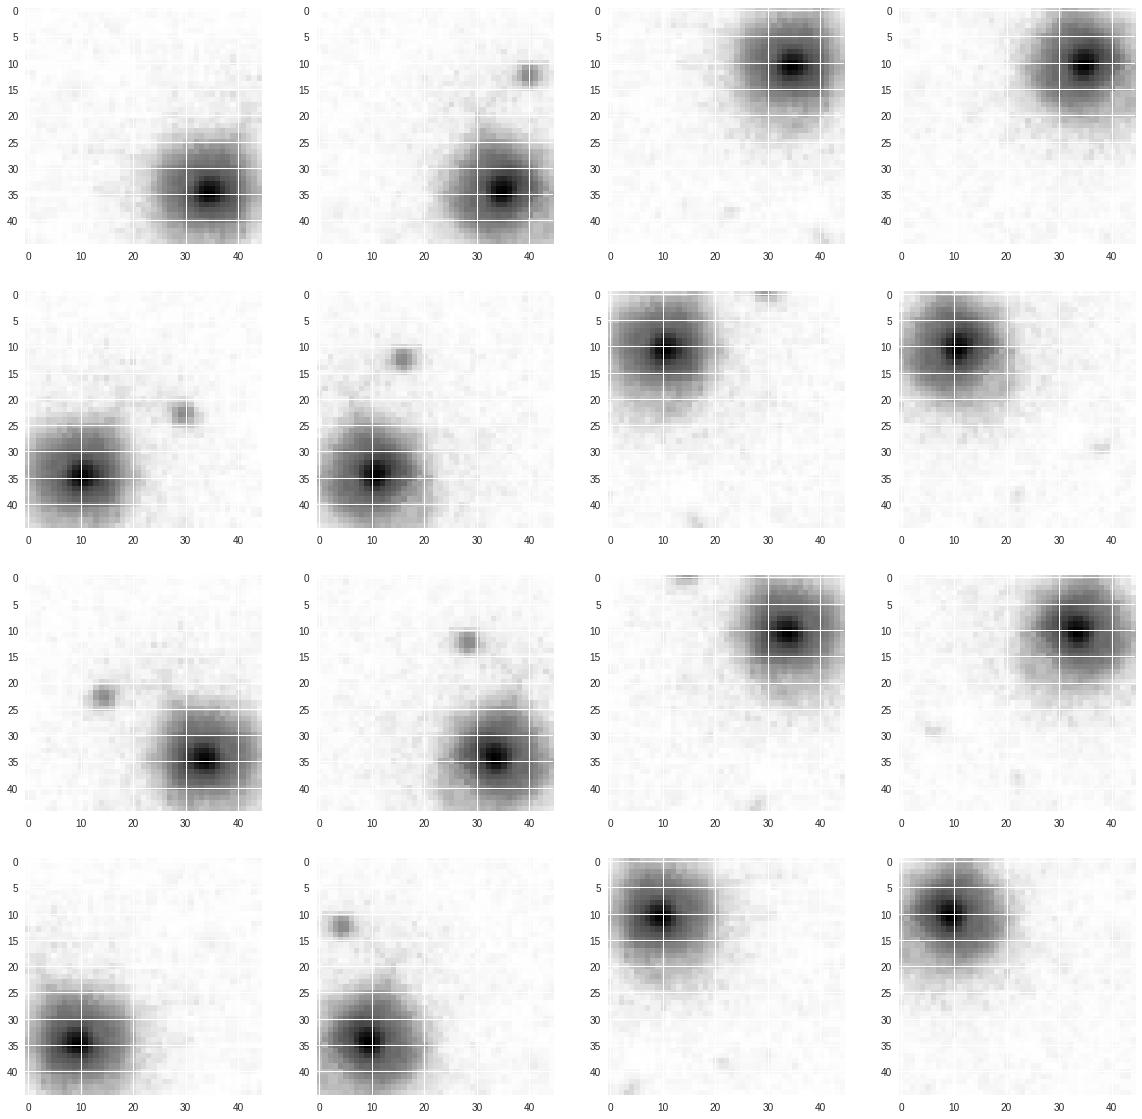

In [9]:
figure(figsize=(20, 20))
for idx in range(16):
    subplot(4, 4, idx + 1)
    imshow(traindata[:, :, 4, idx])

In [10]:
cc_train = []
cc_valid = []
cc_test = []
for i in range(16):
    cc_train.append(np.rollaxis(traindata[:,:,:,i].reshape([45, 45,1, 8000]), 3))
    cc_valid.append(np.rollaxis(validdata[:,:,:,i].reshape([45, 45, 1,1000]), 3))
    cc_test.append(np.rollaxis(testdata[:,:,:,i].reshape([45, 45, 1, 444]), 3))

In [11]:
cc_test[0].shape

(444, 45, 45, 1)

In [12]:
y_train = color[0:8000]
y_valid= color[8000:9000]
y_test = color[9000:]

In [13]:
y_test.shape

(444,)

In [14]:
print(np.sum((color-np.mean(color))**2)/len(color))

0.0560136102531


In [28]:
# ------------------------------------------------------------------------------
# Set up model architecture
# see Figure 4, Figure 8, and Table 2 of Dielemannnnn paper
# ------------------------------------------------------------------------------

# Define architecture for model
#data_shape = [45, 45] #np.shape(x_data)
input_shape = (45, 45, 1)

# merge via concatenation
#branch_list = []
# DOING IT THE HARD WAY   
#x00 = Input(shape=input_shape)
#c00_0 = Conv2D(nb_filter=32, kernel_size=(6,6), strides=1, activation='softplus')(x00)
#p00_0 = MaxPooling2D(pool_size=(2, 2))(c00_0)
#c00_1 = Conv2D(nb_filter=64, kernel_size=(5,5), strides=1, activation='softplus')(p00_0)
#p00_1 = MaxPooling2D(pool_size=(2, 2))(c00_1)
#c00_2 = Conv2D(nb_filter=128, kernel_size=(3,3), strides=1, activation='softplus')(p00_1)
#c00_3 = Conv2D(nb_filter=128, kernel_size=(3,3), strides=1, activation='softplus')(c00_2)
#p00_3 = MaxPooling2D(pool_size=(2, 2))(c00_3)
'''
x00 = Input(shape=input_shape)
c00_0 = Conv2D(nb_filter=32, kernel_size=(6,6), strides=1, activation='softplus')(x00)
p00_0 = MaxPooling2D(pool_size=(2, 2))(c00_0)
c00_1 = Conv2D(nb_filter=64, kernel_size=(5,5), strides=1, activation='softplus')(p00_0)
p00_1 = MaxPooling2D(pool_size=(2, 2))(c00_1)
c02 = Conv2D(nb_filter=128, kernel_size=(3,3), strides=1, activation='softplus')(p00_1)
c03 = Conv2D(nb_filter=128, kernel_size=(3,3), strides=1, activation='softplus')(c02)
p03 = MaxPooling2D(pool_size=(2, 2))(c03)
'''
x00 = Input(shape=input_shape)
x01 = Input(shape=input_shape)
x02 = Input(shape=input_shape)
x03 = Input(shape=input_shape)
x04 = Input(shape=input_shape)
x05 = Input(shape=input_shape)
x06 = Input(shape=input_shape)
x07 = Input(shape=input_shape)
x08 = Input(shape=input_shape)
x09 = Input(shape=input_shape)
x10 = Input(shape=input_shape)
x11 = Input(shape=input_shape)
x12 = Input(shape=input_shape)
x13 = Input(shape=input_shape)
x14 = Input(shape=input_shape)
x15 = Input(shape=input_shape)

#a1 = make_branch(input_shape)
#a2 = make_branch(input_shape)


# switch to Maximum() rather than Concatenate() - There's other work on rotationally invariant CNNs that uses that, but I'll have to find the \cite
# also trims down the width of the network significantly
merge = Maximum()([make_branch(x00),make_branch(x01),make_branch(x02),make_branch(x03),make_branch(x04),make_branch(x05),make_branch(x06),make_branch(x07),make_branch(x08),make_branch(x09),make_branch(x10),make_branch(x11),make_branch(x12),make_branch(x13),make_branch(x14),make_branch(x15)]) #[a1, a2])
#([make_branch() for i in range(16)])

# Dense layers

# add some dropout, use only 512 inputs/outputs, and add ReLUs on dense layers.

mergedrop = Dropout(0.5)(merge)
d0 = Dropout(0.5)((Dense(512, activation='relu')(mergedrop)))
d1 = Dropout(0.5)((Dense(512, activation='relu')(d0)))

#output layer
y = Dense(1)(d1)

model = Model(input=[x00,x01,x02, x03,x04,x05,x06,x07,x08,x09,x10,x11,x12,x13,x14,x15], outputs=y)

# Seems to work better with Adam for me, but SGD+momentum is probably just as good.
optimizer = 'adam'
loss = 'mean_squared_error'
model.compile(loss=loss, optimizer=optimizer)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_17 (InputLayer)            (None, 45, 45, 1)     0                                            
____________________________________________________________________________________________________
input_18 (InputLayer)            (None, 45, 45, 1)     0                                            
____________________________________________________________________________________________________
input_19 (InputLayer)            (None, 45, 45, 1)     0                                            
____________________________________________________________________________________________________
input_20 (InputLayer)            (None, 45, 45, 1)     0                                            
___________________________________________________________________________________________

/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:61: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


In [41]:
y_train_normed = (y_train - y_train.mean()) / y_train.std()
y_valid_normed = (y_valid - y_train.mean()) / y_train.std()
model.fit(x=cc_train, y=y_train_normed, batch_size=16, epochs=12, validation_data=(cc_valid,y_valid_normed), verbose=2)

Train on 8000 samples, validate on 1000 samples
Epoch 1/12
17s - loss: 0.6228 - val_loss: 0.5986
Epoch 2/12
16s - loss: 0.6012 - val_loss: 0.5990
Epoch 3/12
17s - loss: 0.5907 - val_loss: 0.5845
Epoch 4/12
17s - loss: 0.5916 - val_loss: 0.6142
Epoch 5/12
17s - loss: 0.5803 - val_loss: 0.6030
Epoch 6/12
17s - loss: 0.5797 - val_loss: 0.5735
Epoch 7/12
17s - loss: 0.5768 - val_loss: 0.6151
Epoch 8/12
17s - loss: 0.5680 - val_loss: 0.5702
Epoch 9/12
17s - loss: 0.5638 - val_loss: 0.5980
Epoch 10/12
17s - loss: 0.5558 - val_loss: 0.5867
Epoch 11/12
17s - loss: 0.5690 - val_loss: 0.6175
Epoch 12/12
17s - loss: 0.5525 - val_loss: 0.5618


In [42]:
valid_color = model.predict(cc_valid) * y_train.std() + y_train.mean()

(0, 2)

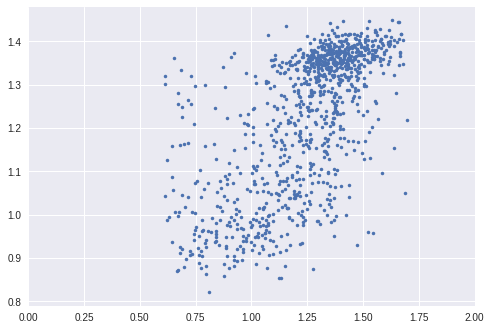

In [43]:
plt.plot(y_valid,valid_color, '.')
plt.xlim([0, 2])
